### Portfolio Optimization ###

Section 1: Preparation

In [169]:
# Import necessary tools (libraries) for data handling, finance data download, dates, and math
import yfinance as yf 
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [170]:
# Define a list of stock symbols (tickers) that for analyzis.
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'JPM', 'GS', 'XOM', 'PG', 'KO', 'JNJ', 'SPY', 'GLD']

In [171]:
# Set the end date for our data to today, and the start date to 10 years ago.
end_date = datetime.today()
start_date = end_date - timedelta (days = 10 * 365)
# verification
print(start_date) 
print (end_date) 

2015-07-28 16:12:06.411218
2025-07-25 16:12:06.411218


Section 2: Download Close Prices

In [173]:
# Create an empty table (DataFrame) to hold the adjusted closing prices of stocks.
adj_close_df = pd.DataFrame()
# Loop through each stock ticker and download its historical 'Close' prices. 'Close' downloaded from yahoo finance are 'Adjusted Close' prices.
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date, progress = False)
    adj_close_df[ticker] = data['Close']

In [174]:
# Display the 'Adjusted Close' prices for AAPL to verify the data download.
adj_close_df['AAPL']

Date
2015-07-28     27.633028
2015-07-29     27.545685
2015-07-30     27.406822
2015-07-31     27.167181
2015-08-03     26.526628
                 ...    
2025-07-21    212.479996
2025-07-22    214.399994
2025-07-23    214.149994
2025-07-24    213.759995
2025-07-25    214.195007
Name: AAPL, Length: 2514, dtype: float64

Section 3: Calculate Lognromal Returns

In [176]:
# Calculate the daily percentage change (returns) for each stock, using logarithms.
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
# Remove any rows that have missing values (e.g., the very first row, which has no previous day to compare to).
log_returns = log_returns.dropna()
# Display the first few rows of the calculated log returns.
print(log_returns.head())
print(log_returns.mean())

                AAPL      MSFT      GOOG      AMZN       JPM        GS  \
Date                                                                     
2015-07-29 -0.003166  0.020737  0.006238  0.005630  0.012994  0.002905   
2015-07-30 -0.005054  0.012665  0.001044  0.014563  0.001449  0.001739   
2015-07-31 -0.008782 -0.003847 -0.011095 -0.001137 -0.007415 -0.010333   
2015-08-03 -0.023861  0.002352  0.008911 -0.002091  0.000000 -0.001855   
2015-08-04 -0.032610  0.015475 -0.003110 -0.005867 -0.001022  0.002342   

                 XOM        PG        KO       JNJ       SPY       GLD  
Date                                                                    
2015-07-29  0.007970  0.004850  0.000986  0.007145  0.006856  0.001427  
2015-07-30 -0.001565 -0.040889 -0.000739  0.001102  0.000237 -0.008594  
2015-07-31 -0.046859 -0.008956  0.012740  0.003699 -0.001519  0.006310  
2015-08-03 -0.014625 -0.003919  0.011135 -0.001898 -0.003379 -0.007942  
2015-08-04 -0.011467 -0.006434  0.007435 -0

Section 4: Calculate Covariance Matrix

In [178]:
# Annualize returns and covariance assuming 252 trading days in a year
annual_returns = log_returns.mean() * 252
# Calculate the covariance matrix using annualized log returns.
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

          AAPL      MSFT      GOOG      AMZN       JPM        GS       XOM  \
AAPL  0.086085  0.054863  0.051974  0.056007  0.035514  0.042314  0.026741   
MSFT  0.054863  0.073708  0.056872  0.060524  0.034237  0.039795  0.021790   
GOOG  0.051974  0.056872  0.082651  0.062813  0.033599  0.039700  0.023399   
AMZN  0.056007  0.060524  0.062813  0.107264  0.029591  0.038716  0.018234   
JPM   0.035514  0.034237  0.033599  0.029591  0.077018  0.068510  0.043343   
GS    0.042314  0.039795  0.039700  0.038716  0.068510  0.088411  0.043713   
XOM   0.026741  0.021790  0.023399  0.018234  0.043343  0.043713  0.079772   
PG    0.019980  0.020028  0.015602  0.013214  0.017043  0.016244  0.013387   
KO    0.018778  0.018604  0.016223  0.012116  0.022178  0.020073  0.019719   
JNJ   0.017517  0.017345  0.014748  0.011891  0.019071  0.018315  0.016405   
SPY   0.040800  0.039957  0.038389  0.039691  0.036932  0.040615  0.028324   
GLD   0.001306  0.001009  0.001614  0.001687 -0.004155 -0.003095

Section 5: Define Portfolio Performance Matrics

In [180]:
# Define a function to calculate the portfolio's standard deviation (risk/vlatility),
def standard_deviation (weights, cov_matrix):
    """
    Calculates the annualized standard deviation (volatility) of a portfolio.
    This function measures the risk of the portfolio – how much its value might fluctuate.
    It uses matrix multiplication to combine individual stock risks and their relationships to represent the combined volatility.

    Formula:
        Portfolio Volatility = sqrt(weights.T @ Covariance_Matrix @ weights)
        Where:
        - weights.T is the transpose of the weights vector.
        - @ denotes matrix multiplication.

    Args:
        weights (np.array): (m,) Array of portfolio weights for each asset,
                            where m is the number of assets.
                            (Represents the proportion of the total investment in each stock/asset).
        cov_matrix (pd.DataFrame or np.array): (m, n) Annualized covariance matrix of asset returns.
                                                (Measures how much each pair of stocks moves together,
                                                scaled to an annual basis).

    Returns:
        float: The annualized portfolio standard deviation (volatility).
    """
    variance = weights.T @ cov_matrix @ weights 
    return np.sqrt(variance)

In [181]:
# Define a function to calculate the portfolio's expected return.
def expected_return (weights, log_returns):
    """
    Calculates the annualized expected return of a portfolio.
    This function estimates how much profit a portfolio is expected to make per year.

    Formula:
        Expected Return = sum( (Average Daily Log Return for each asset * its weight) ) * 252
        Where:
        - 252 is the approximate number of trading days in a year for annualization.

    Args:
        weights (np.array): (m,) Array of portfolio weights for each asset,
                            where m is the number of assets.
        log_returns (pd.DataFrame): (m, n) DataFrame of daily logarithmic returns for assets,
                                    where m is the number of trading days and n is the number of assets.

    Returns:
        float: The annualized expected return of the portfolio.
    """
    return np.sum(log_returns.mean()*weights)*252

In [182]:
# Define a function to calculate the Sharpe Ratio. 
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    """
    Calculates the Sharpe Ratio of a portfolio.
    This ratio helps evaluate the return of an investment compared to its risk.
    A higher Sharpe Ratio means better risk-adjusted returns.

    Formula:
        Sharpe Ratio = (Expected Portfolio Return - Risk-Free Rate) / Portfolio Standard Deviation

    Args:
        weights (np.array): (N,) Array of portfolio weights for each asset.
        log_returns (pd.DataFrame): (M, N) DataFrame of daily logarithmic returns for assets.
        cov_matrix (pd.DataFrame or np.array): (N, N) Annualized covariance matrix of asset returns.
        risk_free_rate (float): The annualized risk-free rate.
                                (Return on an investment with zero risk, like a government bond).

    Returns:
        float: The Sharpe Ratio of the portfolio. Returns -np.inf if weights sum to zero
               to prevent division by zero errors and guide optimization.
    """
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

Section 6: Portfolio Optimization

In [184]:
# Set the risk-free rate, which is the return on an investment with no risk (e.g., a government bond).
risk_free_rate = 0.2

# The commented-out code below shows an alternative way to get the risk-free rate from an external source (FRED).
# fred = Fred(api_key = '895bdf9c71c9f1991abccf3f2f4b9a7e')
# ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

# risk_free_rate = ten_year_treasury_rate.iloc[-1]
# print(risk_free_rate)


In [185]:
# Define a function that returns the negative Sharpe Ratio.
# This is done since the optimization function (scipy.optimize.minimize()) finds minimums, so minimizing the negative Sharpe Ratio maximizes the positive one.
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    """
    Calculates the negative Sharpe Ratio, used for minimization.
    Since the `scipy.optimize.minimize` function finds the lowest value,
    minimizing the negative Sharpe Ratio is done to maximize the positive Sharpe Ratio.
    
    Args:
        weights (np.array): (N,) Array of portfolio weights for each asset.
        log_returns (pd.DataFrame): (M, N) DataFrame of daily logarithmic returns for assets.
        cov_matrix (pd.DataFrame or np.array): (N, N) Annualized covariance matrix of asset returns.
        risk_free_rate (float): The annualized risk-free rate.

    Returns:
        float: The negative Sharpe Ratio.
    """
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

 

# Define constraints for the optimization: the sum of all investment weights must equal 1 (100% of the portfolio).
# The constraints variable is a dictionary with two keys: 'type' and 'fun'. 'type' is set to 'eq', which means "equality constraint," and 'fun' is assigned the function check_sum, which checks if the sum of the portfolio weights equal 1.
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights)-1}

# Set bounds for each weight: each stock's weight must be between 0% (no short selling) and 50% (no more than half of the portfolio in one stock).
bounds = [(0, 0.5) for _ in range(len(tickers))] 

# Set initial weights for the optimization process, starting with an equal distribution across all stocks.
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]


In [186]:
# Use the 'minimize' function to find the optimal portfolio weights.
# It uses a method called 'SLSQP' to find the best weights that maximize the Sharpe Ratio (by minimizing its negative).
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
# In Detail:
# 1. minimize(...):
    # Function from scipy.optimize library. Its main job is to find the input values (in our case, the weights of different stocks)
    # that make a specific function (the first argument) as small as possible.
    # Since the goal is to maximize the Sharpe Ratio (a measure of return per unit of risk), the function neg_sharpe_ratio that returns the negative
    # of the Sharpe Ratio was defined above. By minimizing this negative value, the positive Sharpe Ratio is maximized.
# 2. neg_sharpe_ratio (First argument):
    # Function function that 'minimize' will try to make as small as possible.
# 3. initial_weights (Second argument):
    # The minimize algorithm begins its search for the best weights from this initial set.
# 4. args=(log_returns, cov_matrix, risk_free_rate) (Third argument):
    # Tuple of additional arguments that need to be passed to the neg_sharpe_ratio function besides the weights.
    # The minimize function only changes the weights directly. log_returns, cov_matrix, and risk_free_rate are constant values needed for 
    # the Sharpe Ratio calculation but are not optimized themselves.
# 5. method='SLSQP' (Fourth argument):
    # Particular mathematical algorithm used by minimize to perform the optimization.
    # 'SLSQP' stands for "Sequential Least Squares Quadratic Programming." It is a common and robust method suitable for optimizing functions with both
    # equality and inequality constraints.  It's good at handling problems where the relationships aren't simple straight lines.
# 6. constraints = constraints (Firth argument):
    # Defines the rules the solution must follow.
# 7. bounds=bounds (Sixth argument):
    # This sets the individual limits for each weight.



In [187]:
# Extract the optimal (best) weights found by the optimization process.
optimal_weights = optimized_results.x

Section 7: Analyze the optimal Portfolio

In [189]:
# Print the optimal weights for each stock
print("Optimal Weights:\n")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")
print("\n")

# Calculate the expected annual return, volatility, and Sharpe Ratio for the portfolio with the optimal weights.
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

# Print the calculated performance metrics for the optimal portfolio.
print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")


Optimal Weights:

AAPL: 0.0394
MSFT: 0.5000
GOOG: 0.0000
AMZN: 0.4606
JPM: 0.0000
GS: 0.0000
XOM: 0.0000
PG: 0.0000
KO: 0.0000
JNJ: 0.0000
SPY: 0.0000
GLD: 0.0000


Expected Annual Return: 0.2373
Expected Volatility: 0.2709
Sharpe Ratio: 0.1379


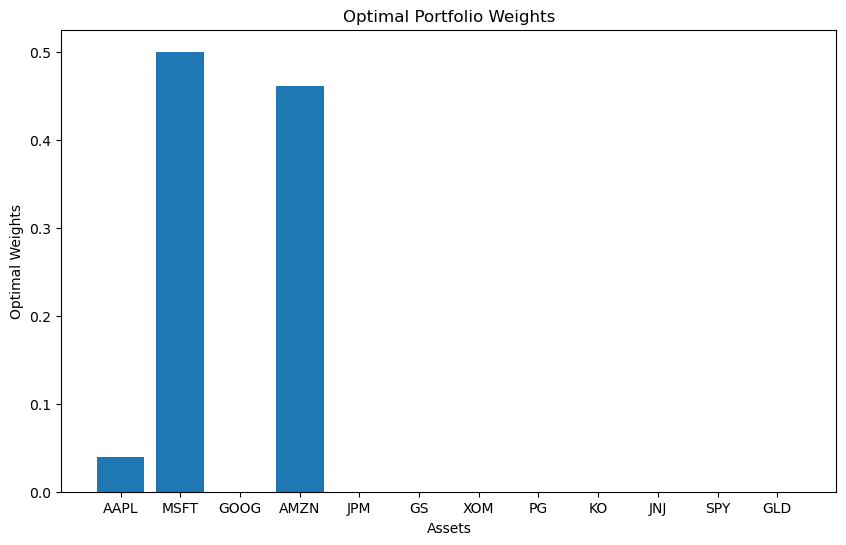

In [190]:
import matplotlib.pyplot as plt # Import the plotting library

# Plot optimal weights against assets in a bar chart
plt.figure(figsize=(10,6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

Section LAST: Further Optimization Strategies

# 1. 'SLSQP' method used by `scipy.optimize.minimize`: 
    # 'SLSQP' method used by `scipy.optimize.minimize` is a "local optimizer".
    # This means it finds the best solution (the lowest point for the negative Sharpe Ratio)
    # in the immediate "neighborhood" of its starting point (`initial_weights`).
        # Strategy 1: Multiple Random Starts (Recommended for practical global search)
        # To increase the chance of finding the *global* minimum (the absolute best Sharpe Ratio
        # across all possible portfolios), run the optimization multiple times.
        # For each iteration, a randomly generated set of `initial_weights` can be used.
        # Then, compare the Sharpe Ratios from all these runs and pick the portfolio
        # that yielded the highest Sharpe Ratio.